### 0. Explicación de usos relevantes de la IA

El uso principal que hemos hecho de la IA es para poder entender el código o hacer lluvia de ideas de posibles soluciones.
Los cambios más significativos potenciados por la IA son.

*  **La reestructuración del código.**

Explicación:

El código anteriormente era muy dificil de comprender debido a que era una mezcla de código propio y código de los ejecicios de clase.

Qué se hizo:

Se decargó el cuaderno y se creó un script de python que extrallese el código se le pasó este código a ChatGPT con la instrucción de que lo ordenase. Luego este código se pegó cambiando algunas cosas para poder entender mejor la estructuración de este y quitar cosas innecesarias.
*   **La optimización del Árbol.**

Explicación:

El código de optimización del árbol no estaba funcionando bien y aun con cambio de las variables seguía sin mejorar.

Qué se hizo:

Se preguntó a ChatGPT posibles razones de la no mejora o posibles formas de mejorar.

Se preguntó:

* Si la relacion de las variables era lineal de forma que se pueda optimizar una y luego la otra ...

Respondio que no es posible.

* La posibilidad de que si se reduciera el cv hubiera menos overfiting

Respondio que esto es erroneo ya que no afecta a las épocas de entrenamiento.

* La posibilidad de que se evaluasen los modelos en un train_validation que no haya sido utilizado para el entrenamiento.

Verificó la posibilidad de hacerlo aun que la mejora es marginal.




### 1. Carga de datos y preprocesamiento (post eda)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import time

# Definir semilla
NIA = "100451061"
SEED = int(NIA[-2]) + int(NIA[-1])

# Cargar datos
df = pd.read_csv(f"/content/attrition_availabledata_0{SEED}.csv")

# Separar variables
X = df.drop(columns=["Attrition_Yes"])
y = df["Attrition_Yes"]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, stratify=y)

Por la naturaleza desbalanceada del dataset, visto en la eda. (El porcentaje de si o no en la variable Attrition no es ~50%)

Es más util usar la exactitud balanceada que es la media entre el porcentaje de acierto en el si y el porcentaje de acierto en el no

### 2. Función para entrenar y evaluar modelos

In [ ]:
# Esta función encapsula todo el fit de los splits de las variables, la predicción y la evaluación cruzada en uno
# Con el objetivo de automatizar estas acciones repetitivas y hacer que el código sea más legible
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, cv_folds=5, scoring='balanced_accuracy', echo = True):
    """Entrena un modelo, calcula su exactitud y realiza validación cruzada"""

    # Como el modelo lo creamos mediante Pipelines tenemos que sacar el modelo del pipeline
    if isinstance(model, Pipeline):
        model_name = model.steps[-1][1].__class__.__name__
        estimator = model.steps[-1][1]
    else:
        model_name = model.__class__.__name__
        estimator = model


    # Medir tiempo de entrenamiento
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train
    y_pred = model.predict(X_test)

    acc = metrics.balanced_accuracy_score(y_test, y_pred)
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    if echo:
        print(f"\nModelo: {model_name}")
        print(f"Accuracy Balanceado: {acc:.2f}")
        print(f"Cross-validation mean: {scores.mean():.2f} ± {scores.std():.2f}")
        print(f"Tiempo de entrenamiento: {train_time:.4f} segundos")

    if isinstance(model, Pipeline): # Devolverá el Pipeline y el modelo en caso de usar pipeline
        return estimator, model, acc, train_time
    else:
        return estimator, acc, train_time

### 3. Entrenamiento y Evaluación de KNN

In [ ]:
# Creamos el modelo default KNN
knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

train_and_evaluate_model(knn_pipeline, X_train, y_train, X_test, y_test)



Modelo: KNeighborsClassifier
Accuracy Balanceado: 0.60
Cross-validation mean: 0.60 ± 0.02
Tiempo de entrenamiento: 0.0146 segundos


(KNeighborsClassifier(),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())]),
 np.float64(0.6010892189236138),
 0.014635086059570312)

### 4. Optimización de hiperparámetros y elección de escalado e imputación para KNN

In [ ]:
# Creamos el modelo con todos los valores de vecinos desde 1 a 20, con todos los diferentes Escaladores y y evaluamos el mejor

scalers = {
    'minmax': MinMaxScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

imputers = { # Estos no serán útiles ya que en el EDA ya decidimos llenar los NA pero si no lo hubieramos hecho si que serviría
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median')
}

# Crear combinaciones en la pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer()),  # Cambiará pero tiene que tener uno de inicio
    ('scaler', MinMaxScaler()),    # Cambiará pero tiene que tener uno de inicio
    ('knn', KNeighborsClassifier())
])

# Definir los parámetros a buscar
param_grid = {
    'imputer': [imputers['mean'], imputers['median']],
    'scaler': [scalers['minmax'], scalers['standard'], scalers['robust']]
}

# Optimización con GridSearch
grid_knn = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy')
grid_knn.fit(X_train, y_train)

# Mostrar mejores parámetros
print(f"Mejores hiperparámetros para KNN: {grid_knn.best_params_}")

# Evaluación con el mejor modelo
best_knn = grid_knn.best_estimator_

pipeline = Pipeline([
    ('imputer', best_knn.named_steps['imputer']),
    ('scaler', best_knn.named_steps['scaler']),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Definir los parámetros a buscar
param_grid = {
    'knn__n_neighbors': range(1, 20, 1)  # Ajustando número de vecinos
}

# Optimización con GridSearch
grid_knn = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy')
grid_knn.fit(X_train, y_train)


# Evaluación con el mejor modelo
best_knn = grid_knn.best_estimator_


# Mostrar mejores parámetros
print(f"Mejores hiperparámetros para KNN: {grid_knn.best_params_}")

train_and_evaluate_model(best_knn, X_train, y_train, X_test, y_test)

Mejores hiperparámetros para KNN: {'imputer': SimpleImputer(), 'scaler': RobustScaler()}
Mejores hiperparámetros para KNN: {'knn__n_neighbors': 1}

Modelo: KNeighborsClassifier
Accuracy Balanceado: 0.82
Cross-validation mean: 0.82 ± 0.03
Tiempo de entrenamiento: 0.0458 segundos


(KNeighborsClassifier(n_neighbors=1),
 Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', RobustScaler()),
                 ('knn', KNeighborsClassifier(n_neighbors=1))]),
 np.float64(0.8185378487926258),
 0.04583573341369629)

Se observa una clara mejora de un 59% de acierto, casi una moneda, a un 82% de acierto.


### 5. Entrenamiento y Evaluación de Árbol de Decisión


Modelo: DecisionTreeClassifier
Accuracy Balanceado: 0.76
Cross-validation mean: 0.79 ± 0.02
Tiempo de entrenamiento: 0.0846 segundos


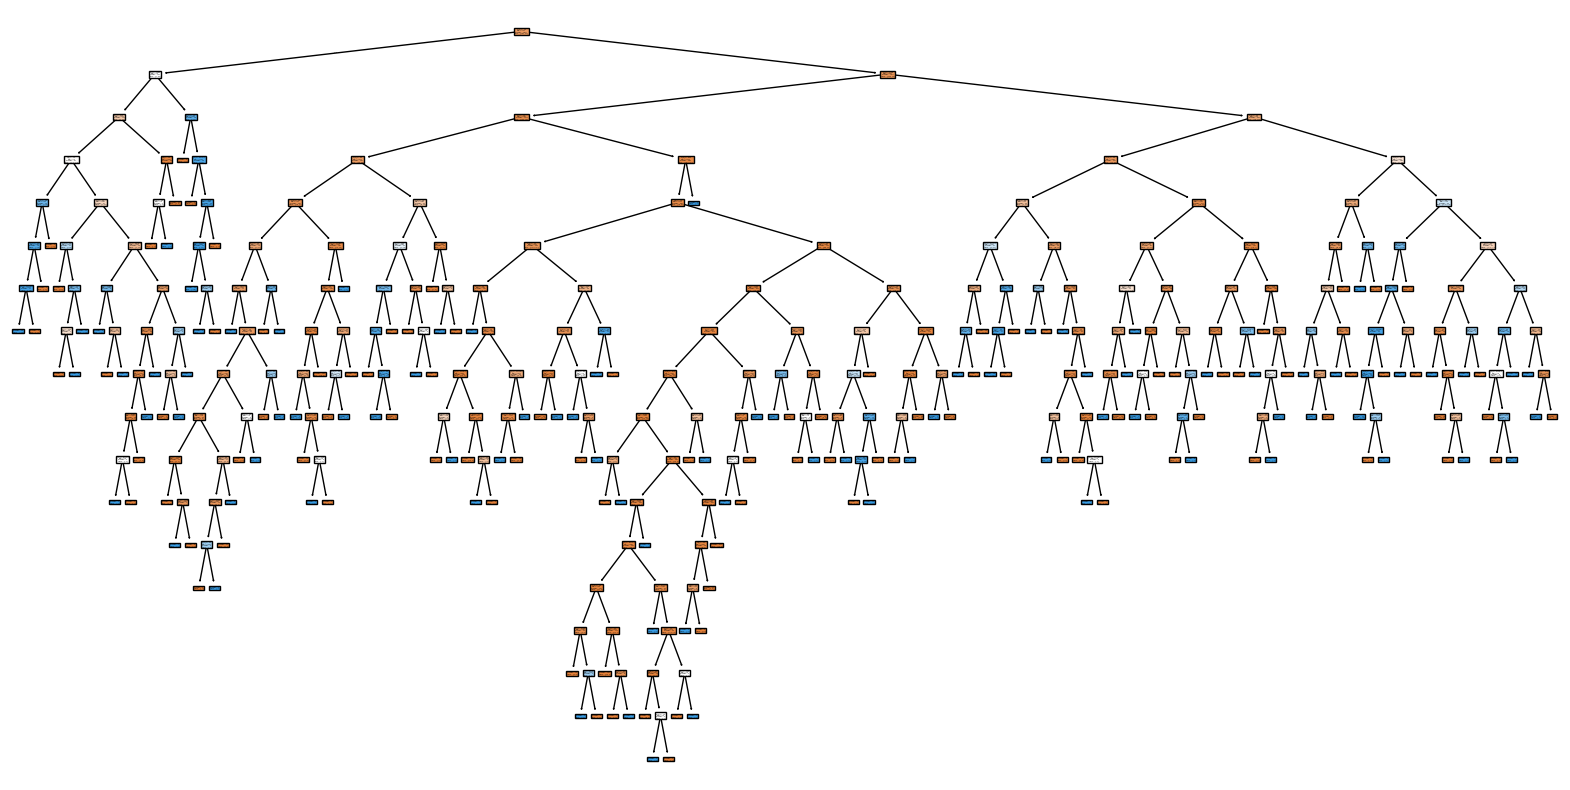

In [ ]:
# Creamos el árbol de decisión
tree_model = DecisionTreeClassifier(random_state=SEED)
train_and_evaluate_model(tree_model, X_train, y_train, X_test, y_test)

# Dibujamos el árbol
fig = plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True)
plt.show()

### 6. Optimización de hiperparámetros para Árbol de Decisión

In [ ]:
# Probamos con diferentes parámetros el Árbol de decisión

# Dividimos X_train en un subconjunto de entrenamiento y otro de validación
# Esto es para que el Grid Search use el eval para evaluar por que antes sino nos
# daba mucho overfiting y de esta forma lo evitamos.

X_train_sub, X_eval, y_train_sub, y_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# Definimos los hiperparámetros a probar esto creará 2000 modelos.
param_dist = {
    'max_depth': np.arange(1, 20, 2),
    'min_samples_split': np.arange(2, 10, 2),
    'min_samples_leaf': np.arange(1, 10, 2)
}

# Configuramos GridSearchCV
grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=SEED), param_dist, cv=5, scoring='balanced_accuracy'
)

# Ajustamos GridSearch solo con X_train_sub
grid_tree.fit(X_train_sub, y_train_sub)

# Mejor modelo encontrado
best_tree = grid_tree.best_estimator_

# Evaluamos en el conjunto de validación
y_eval_pred = best_tree.predict(X_eval)
eval_score = balanced_accuracy_score(y_eval, y_eval_pred)

# Evaluación final en el test set
train_and_evaluate_model(best_tree, X_train, y_train, X_test, y_test)

print(f"\nMejores hiperparámetros para Árbol de Decisión: {grid_tree.best_params_}")
print(f"Balanced Accuracy en Validación: {eval_score:.2f}")


Modelo: DecisionTreeClassifier
Accuracy Balanceado: 0.75
Cross-validation mean: 0.79 ± 0.03
Tiempo de entrenamiento: 0.0187 segundos

Mejores hiperparámetros para Árbol de Decisión: {'max_depth': np.int64(11), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2)}
Balanced Accuracy en Validación: 0.82


In [ ]:
# Mejora marginal del modelo base por ello hacemos un checkeo de overfitting
print("Train accuracy:", best_tree.score(X_train, y_train))
print("Test accuracy:", best_tree.score(X_test, y_test))

Train accuracy: 0.9939055358049771
Test accuracy: 0.8815653964984552


In [ ]:
# Obtenemos los valores basados en la evolución de max_depth
param_dist = {
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Configuramos GridSearchCV
grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=SEED), param_dist, cv=5, scoring='balanced_accuracy'
)

# Ajustamos GridSearch solo con X_train_sub
grid_tree.fit(X_train_sub, y_train_sub)

# Mejor modelo encontrado
best_tree = grid_tree.best_estimator_

# Evaluamos en el conjunto de validación
y_eval_pred = best_tree.predict(X_eval)
eval_score = balanced_accuracy_score(y_eval, y_eval_pred)

# Evaluación final en el test set
train_and_evaluate_model(best_tree, X_train, y_train, X_test, y_test)


Modelo: DecisionTreeClassifier
Accuracy Balanceado: 0.75
Cross-validation mean: 0.79 ± 0.03
Tiempo de entrenamiento: 0.0194 segundos


(DecisionTreeClassifier(max_depth=np.int64(11), random_state=7),
 np.float64(0.7519992488145355),
 0.019433975219726562)

Concluimos que hay overfiting incluso sin usar train para evaluar

### 7. Evaluación con gráfico de acuracy, y tiempo de ejecución.

Tiempo de entrenamiento dummy: 0.0020194053649902344
Tiempo de entrenamiento default: 0.006647825241088867
Tiempo de entrenamiento mejorado 0.01782846450805664


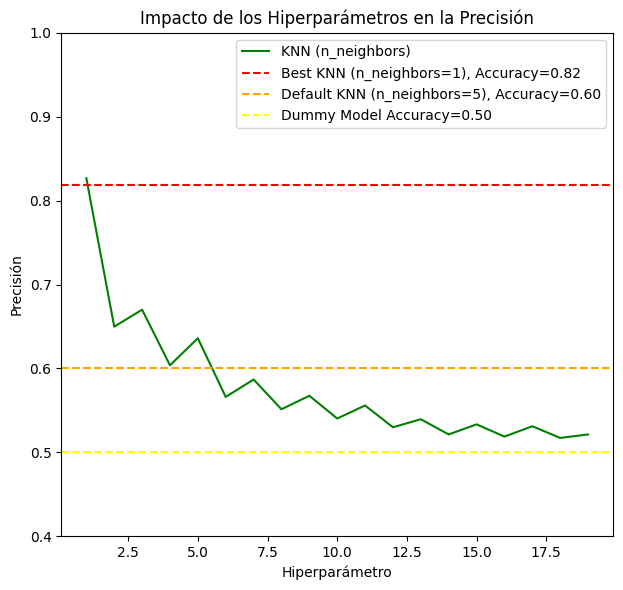

In [ ]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model, dummy_acc, dummy_train_time = train_and_evaluate_model(dummy_model, X_train, y_train, X_test, y_test, echo=False)

# Evaluación del KNN
knn_model, knn_pipeline, knn_acc, knn_train_time = train_and_evaluate_model(knn_pipeline, X_train, y_train, X_test, y_test, echo=False)
best_knn_model,best_knn_pipeline, best_knn_acc, best_knn_train_time = train_and_evaluate_model(best_knn, X_train, y_train, X_test, y_test, echo=False)
knn_accuracies = grid_knn.cv_results_['mean_test_score']

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(range(1,len(knn_accuracies)+1), knn_accuracies, label='KNN (n_neighbors)', color='g')
plt.axhline(y=best_knn_acc , linestyle='--', color='r', label=f'Best KNN (n_neighbors={best_knn_pipeline.named_steps.get("knn", None).n_neighbors }), Accuracy={best_knn_acc:.2f}')
plt.axhline(y=knn_acc , linestyle='--', color='orange', label=f'Default KNN (n_neighbors={knn_pipeline.named_steps.get("knn", None).n_neighbors }), Accuracy={knn_acc:.2f}')
plt.axhline(y=dummy_acc, linestyle='--', color='yellow', label=f'Dummy Model Accuracy={dummy_acc:.2f}')
plt.title('Impacto de los Hiperparámetros en la Precisión')
plt.xlabel('Hiperparámetro')
plt.ylabel('Precisión')
plt.legend()
plt.ylim(0.4, 1)

# Gráfico de tiempo de computación
print(f"Tiempo de entrenamiento dummy: {dummy_train_time}\nTiempo de entrenamiento default: {knn_train_time}\nTiempo de entrenamiento mejorado {best_knn_train_time}")

plt.tight_layout()
plt.show()




Modelo: DecisionTreeClassifier
Accuracy Balanceado: 0.76
Cross-validation mean: 0.79 ± 0.02
Tiempo de entrenamiento: 0.0726 segundos

Modelo: DecisionTreeClassifier
Accuracy Balanceado: 0.75
Cross-validation mean: 0.79 ± 0.03
Tiempo de entrenamiento: 0.0635 segundos
Tiempo de computación dummy: 0.0020194053649902344
Tiempo de computación default: 0.07260680198669434
Tiempo de computacion mejorado 0.06354880332946777


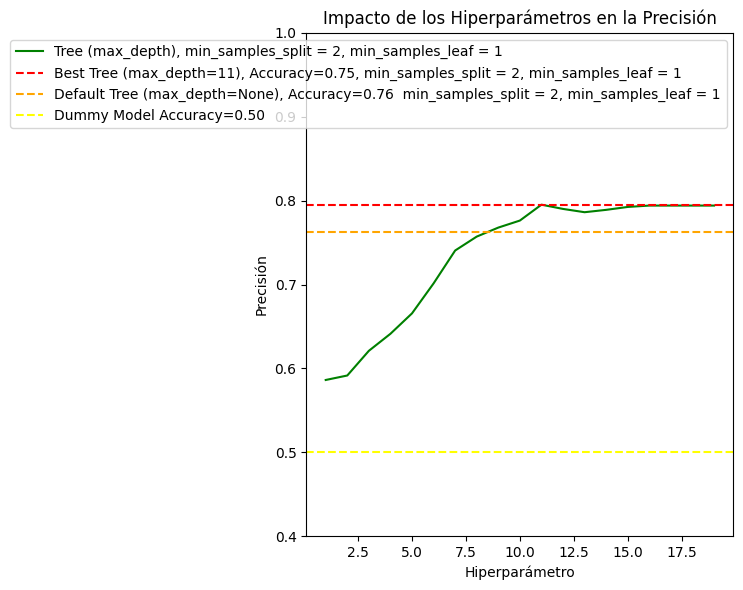

In [ ]:
# Evaluación del KNN
tree_model, tree_acc, tree_train_time = train_and_evaluate_model(tree_model, X_train, y_train, X_test, y_test)
best_tree_model, best_tree_acc, best_tree_train_time = train_and_evaluate_model(best_tree, X_train, y_train, X_test, y_test)
tree_accuracies = grid_tree.cv_results_['mean_test_score']

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(range(1,len(tree_accuracies)+1), tree_accuracies, label='Tree (max_depth), min_samples_split = 2, min_samples_leaf = 1', color='g')
plt.axhline(y=max(tree_accuracies) , linestyle='--', color='r', label=f'Best Tree (max_depth={list(tree_accuracies).index(max(tree_accuracies))+1}), Accuracy={best_tree_acc:.2f}, min_samples_split = 2, min_samples_leaf = 1')
plt.axhline(y=tree_acc , linestyle='--', color='orange', label=f'Default Tree (max_depth={tree_model.get_params()["max_depth"]}), Accuracy={tree_acc:.2f}  min_samples_split = {tree_model.get_params()["min_samples_split"]}, min_samples_leaf = {tree_model.get_params()["min_samples_leaf"]}')
plt.axhline(y=dummy_acc, linestyle='--', color='yellow', label=f'Dummy Model Accuracy={dummy_acc:.2f}')
plt.title('Impacto de los Hiperparámetros en la Precisión')
plt.xlabel('Hiperparámetro')
plt.ylabel('Precisión')
plt.legend()
plt.ylim(0.4, 1)

# Gráfico de tiempo de computación
print(f"Tiempo de computación dummy: {dummy_train_time}\nTiempo de computación default: {tree_train_time}\nTiempo de computacion mejorado {best_tree_train_time}")

plt.tight_layout()
plt.show()

10